In [12]:
# import modules
import os
from glob import glob
import joblib

import torch
import torch.nn as nn
import torchvision.models as models

from fogvision import gpuutils
from fogvision import fogimageclass

# FogVision image classification models
There are two fogvision inference classification heads one for diurnal and one for nocturnal imagery; both working with resnet50 embeddings

In [ ]:
# initialize embedder 
basemodel = models.resnet50(pretrained=True)

num_ftrs = basemodel.fc.in_features
basemodel.fc = nn.Identity()  # Set the classification layer to identity to output embeddings

# choose device
device = gpuutils.get_gpu_most_memory() # if gpus avaible get one with most memory
print(device)

# put the model in evaluation mode
model = basemodel.to(device)
model.eval()


# initialize classification heads (saved from cpu)
if 'cpu' in str(device):
    diurnal_classif_head = torch.load(os.path.join('models', f'fogvision_inference_head_model_diurnal_cpu.pkl'), map_location=device) # NOTE when running model on cpu
    nocturnal_classif_head = torch.load(os.path.join('models', f'fogvision_inference_head_model_nocturnal_cpu.pkl'), map_location=device) # when loading onto cuda
else:
    diurnal_classif_head = joblib.load(os.path.join('models', f'fogvision_inference_head_model_diurnal.pkl')) # NOTE when loading onto cuda
    nocturnal_classif_head = joblib.load(os.path.join('models', f'fogvision_inference_head_model_nocturnal.pkl')) 



c:\Users\jnicolow\AppData\Local\anaconda3\envs\fogvision\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jnicolow\AppData\Local\anaconda3\envs\fogvision\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


# FogVision image classification
The fog image class can be used to classify images (as shown below). Given the image filepath, the embedding mode and the classification head model.

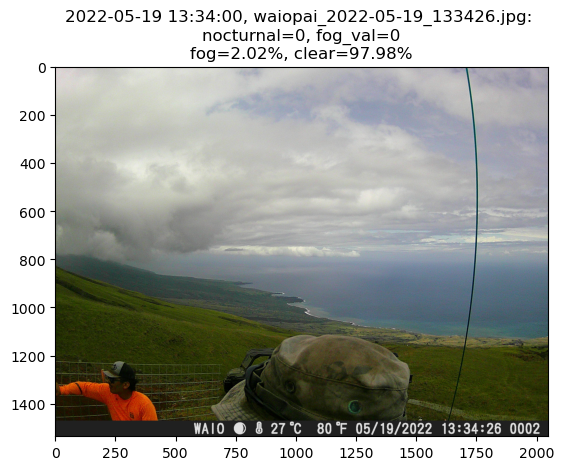

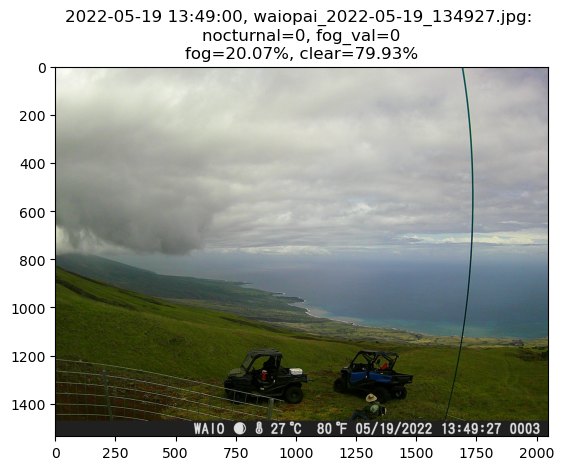

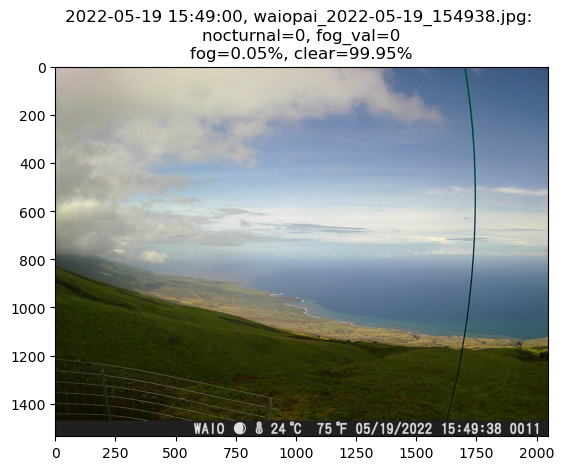

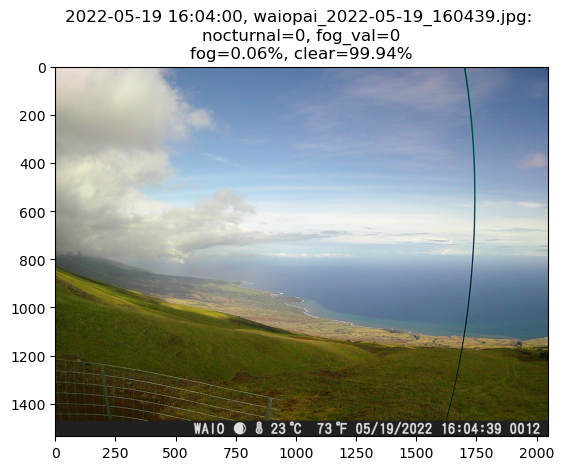

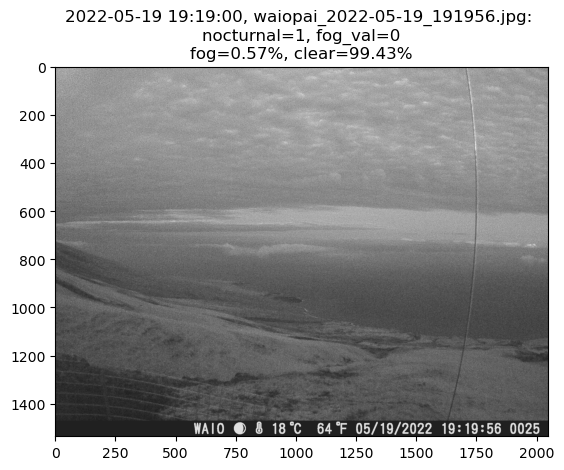

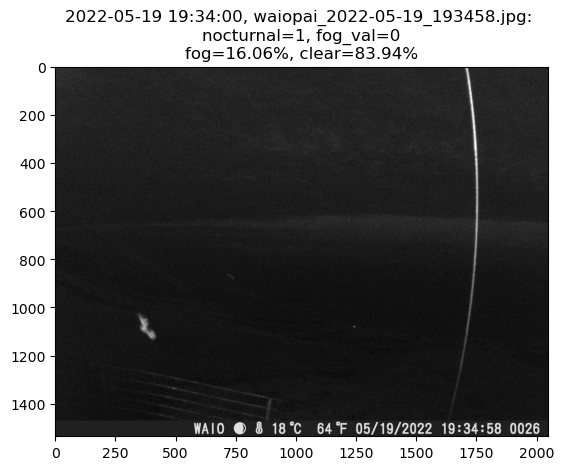

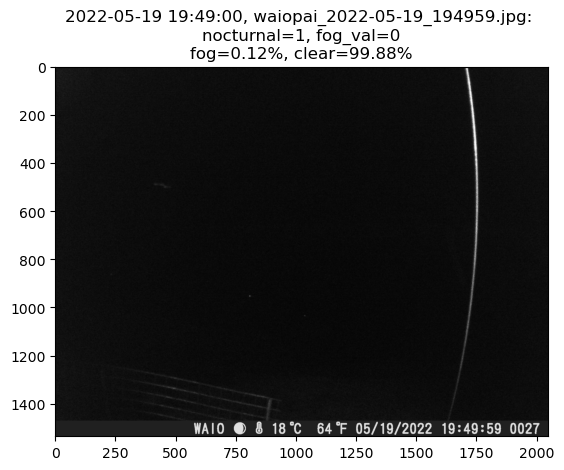

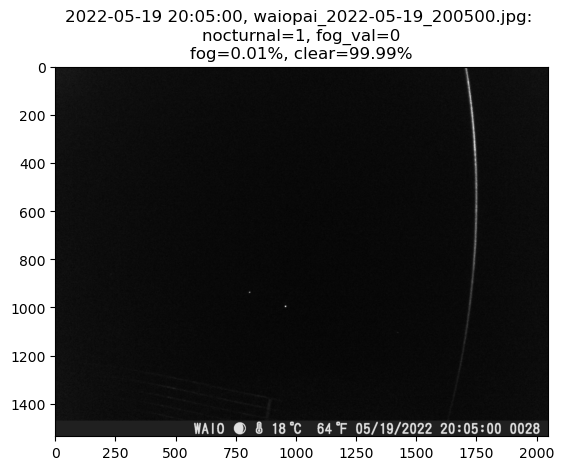

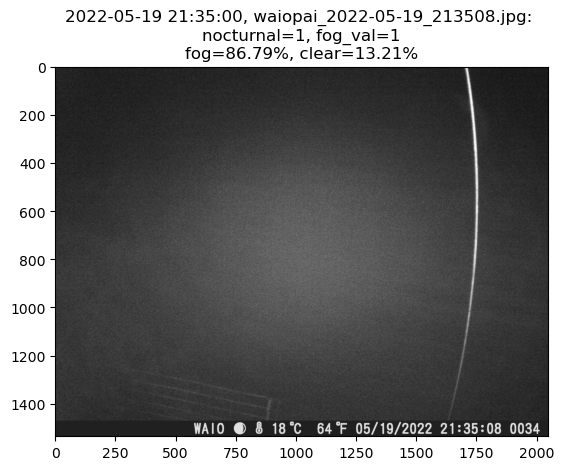

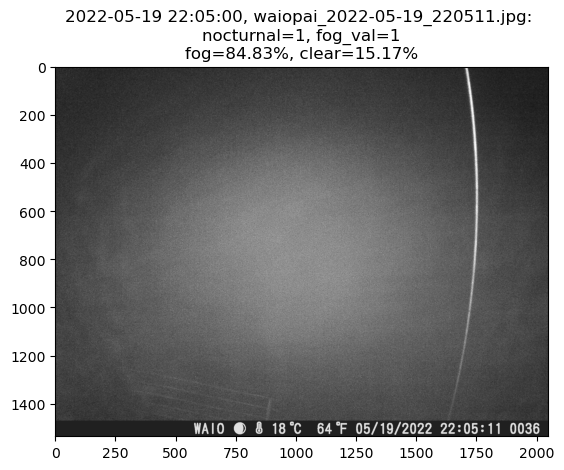

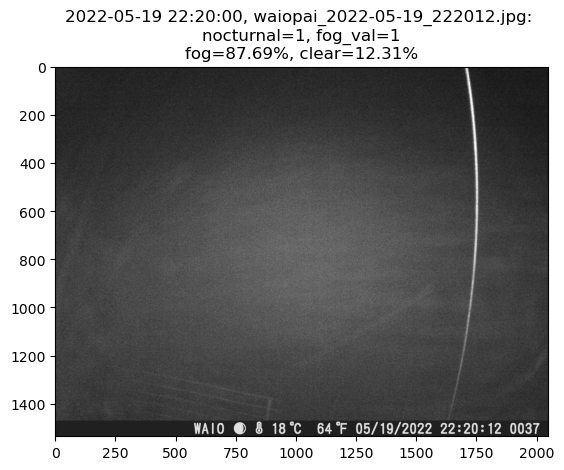

In [ ]:
import importlib
importlib.reload(fogimageclass)
image_fns = glob(os.path.join('data', 'images', '*.jpg'))

crop_size = None # if crop size is None then it will take largest crop possible

for fn in image_fns:
    fog_img_class = fogimageclass.FogImage(filepath=fn, crop_size=crop_size)
    if fog_img_class.nocturnal:
        fog_img_class.get_fog_val(model=nocturnal_classif_head, embedding_model=basemodel, random_crop=False) # NOTE only takes image embedding from 
        # fog_img_class.get_fog_val_multiple_regions(model=nocturnal_classif_head, embedding_model=basemodel) # NOTE not ideal for images with a lot of open sky works best on forested environments
    else:
        fog_img_class.get_fog_val(model=diurnal_classif_head, embedding_model=basemodel, random_crop=False)
        # fog_img_class.get_fog_val_multiple_regions(model=diurnal_classif_head, embedding_model=basemodel)

    fog_img_class.plot_image(plot_crop=False) # plot image with nocturnal and fog value
